In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from pathlib import Path
from tqdm import tqdm
import mne
from mne_bids import BIDSPath

cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'
fontsize = 7

recon_dir = '/cwork/ns458/ECoG_Recon/'

In [2]:
# 加载insula电极数据
task = ['PhonemeSequence', 'SentenceRep', 'TIMIT', 'LexicalDelay']
ref = 'bipolar'

stats_paths = []
for t in task:
    stats_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='coord',
            check=False,
        ).match()
    )

coords = []
for path in tqdm(stats_paths):
    df = pd.read_csv(path)
    coords.append(df)
    
coords = pd.concat(coords)
coords.loc[coords.roi == 'INS', 'roi'] = 'Insula'

# 筛选insula电极
coords_insula = coords[coords.roi == 'Insula'].drop_duplicates(subset=['channel'])
coords_insula = coords_insula[
    coords_insula.label.str.contains('G_insular_short') |
    coords_insula.label.str.contains('G_Ins_lg_and_S_cent_ins')
]

print(f"Total insula electrodes: {len(coords_insula)}")
print(f"Subjects with insula electrodes:")
print(coords_insula.groupby('subject').size().sort_values(ascending=False))

100%|██████████| 663/663 [00:01<00:00, 471.06it/s]


Total insula electrodes: 130
Subjects with insula electrodes:
subject
D0096    9
D0086    9
D0045    7
D0090    7
D0095    7
D0103    6
D0084    6
D0080    5
D0092    5
D0075    5
D0033    5
D0071    5
D0060    5
D0028    4
D0079    4
D0101    4
D0049    3
D0035    3
D0055    3
D0094    3
D0085    3
D0102    3
D0032    2
D0117    2
D0053    2
D0063    2
D0067    2
D0088    2
D0007    1
D0065    1
D0047    1
D0038    1
D0058    1
D0042    1
D0093    1
dtype: int64


In [3]:
# 电极坐标加载和MRI可视化函数
def load_electrode_coords(subject_id, recon_dir):
    """加载个体电极的native RAS坐标"""
    # 处理subject ID格式 (D0023 -> D23)
    short_id = subject_id.replace('D00', 'D0').replace('D0', 'D')
    elec_file = Path(recon_dir) / short_id / 'elec_recon' / f'{short_id}_elec_locations_RAS.txt'
    
    if not elec_file.exists():
        print(f"Electrode file not found: {elec_file}")
        return None
    
    electrodes = []
    with open(elec_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                name = parts[0] + parts[1]  # e.g., "RPMF" + "16"
                x, y, z = float(parts[2]), float(parts[3]), float(parts[4])
                electrodes.append({'name': name, 'x': x, 'y': y, 'z': z})
    
    return pd.DataFrame(electrodes)

def load_mri(subject_id, recon_dir):
    """加载个体MRI (orig.mgz)"""
    short_id = subject_id.replace('D00', 'D0').replace('D0', 'D')
    mri_file = Path(recon_dir) / short_id / 'mri' / 'orig.mgz'
    
    if not mri_file.exists():
        print(f"MRI file not found: {mri_file}")
        return None, None
    
    img = nib.load(mri_file)
    return img.get_fdata(), img.affine

def ras_to_voxel(ras_coords, affine):
    """将RAS坐标转换为voxel坐标"""
    inv_affine = np.linalg.inv(affine)
    ras_homog = np.append(ras_coords, 1)
    voxel = inv_affine @ ras_homog
    return voxel[:3].astype(int)

def get_insula_electrodes_for_subject(subject_id, coords_insula):
    """获取某个subject的insula电极名称（转换为native格式）"""
    sub_df = coords_insula[coords_insula['subject'] == subject_id].copy()
    if len(sub_df) == 0:
        return []
    
    # 从channel名称提取电极名 (e.g., D0023_R2IF1-2 -> R2IF1, R2IF2)
    elec_names = []
    for ch in sub_df['channel']:
        parts = ch.split('_')[1]  # R2IF1-2
        base, nums = parts.rsplit('-', 1) if '-' in parts else (parts, '')
        # 提取基础名和数字
        import re
        match = re.match(r'([A-Za-z]+)(\d+)', base)
        if match:
            prefix = match.group(1)
            num1 = match.group(2)
            elec_names.append(f"{prefix}{num1}")
            if nums:
                elec_names.append(f"{prefix}{nums}")
    
    return list(set(elec_names))

Testing with subject: D0086


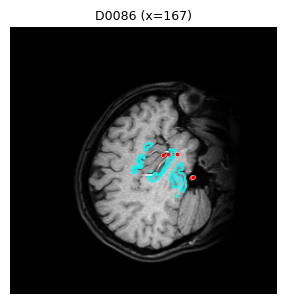

,name,x,y,z
11,LPI4,-34.5000,0.2587,-4.2056
12,LPI3,-35.0000,0.4105,-8.9468
13,LPI2,-35.5000,0.5622,-13.6879
14,LPI1,-36.0000,0.7140,-18.4290
84,LTPI3,-42.5960,-22.0878,-31.2460
85,LTPI2,-39.0170,-21.4504,-32.2170
86,LTPI1,-35.4380,-20.8130,-33.1880
125,RPI5,31.5000,-3.0000,-2.5000
126,RPI4,32.1250,-3.2500,-6.7500
173,RTPI4,42.8675,-19.2672,-29.1597


In [14]:
# 在MRI切片上显示电极位置 - 改进版
def load_parcellation(subject_id, recon_dir):
    """加载个体parcellation (aparc.a2009s+aseg.mgz)"""
    short_id = subject_id.replace('D00', 'D0').replace('D0', 'D')
    parc_file = Path(recon_dir) / short_id / 'mri' / 'aparc.a2009s+aseg.mgz'
    
    if not parc_file.exists():
        print(f"Parcellation file not found: {parc_file}")
        return None
    
    img = nib.load(parc_file)
    return img.get_fdata()

# Insula labels in FreeSurfer aparc.a2009s+aseg
# Left: 11148 (G_insular_short), 11149 (G_Ins_lg_and_S_cent_ins), 11150-11152 (S_circular_insula)
# Right: 12148, 12149, 12150-12152
INSULA_LABELS_LH = [11148, 11149, 11150, 11151, 11152]
INSULA_LABELS_RH = [12148, 12149, 12150, 12151, 12152]

def plot_electrode_on_mri(subject_id, coords_insula, recon_dir, slice_offset=0):
    """在MRI sagittal切片上显示电极位置，类似eLife论文图片"""
    # 加载数据
    all_elec_df = load_electrode_coords(subject_id, recon_dir)
    mri_data, affine = load_mri(subject_id, recon_dir)
    parc_data = load_parcellation(subject_id, recon_dir)
    
    if all_elec_df is None or mri_data is None:
        return None
    
    # 获取该subject的insula电极名称
    target_elecs = get_insula_electrodes_for_subject(subject_id, coords_insula)
    if len(target_elecs) == 0:
        print(f"No insula electrodes found for {subject_id}")
        return None
    
    # 筛选目标电极
    elec_df = all_elec_df[all_elec_df['name'].isin(target_elecs)]
    
    if len(elec_df) == 0:
        elec_df = all_elec_df[all_elec_df['name'].apply(
            lambda x: any(t in x for t in target_elecs)
        )]
    
    if len(elec_df) == 0:
        print(f"Could not match electrodes for {subject_id}")
        return None
    
    # 获取电极的voxel坐标
    voxel_coords = []
    for _, row in elec_df.iterrows():
        ras = np.array([row['x'], row['y'], row['z']])
        vox = ras_to_voxel(ras, affine)
        voxel_coords.append(vox)
    voxel_coords = np.array(voxel_coords)
    
    # 计算sagittal切片位置（电极x坐标的中位数）
    x_slice = int(np.median(voxel_coords[:, 0])) + slice_offset
    
    # 判断左右半球
    is_left = x_slice > mri_data.shape[0] // 2
    insula_labels = INSULA_LABELS_LH if is_left else INSULA_LABELS_RH
    
    # 绘图 - 类似eLife论文风格
    fig, ax = plt.subplots(1, 1, figsize=(8*cm, 8*cm))
    
    # Sagittal view - 正确的方向：origin='lower' 让z轴朝上
    # 取切片后转置，使y轴水平，z轴垂直
    mri_slice = mri_data[x_slice, :, :].T
    ax.imshow(mri_slice, cmap='gray', origin='lower', aspect='equal')
    
    # 添加insula轮廓
    if parc_data is not None:
        parc_slice = parc_data[x_slice, :, :].T
        insula_mask = np.isin(parc_slice, insula_labels)
        if insula_mask.any():
            ax.contour(insula_mask, levels=[0.5], colors=['cyan'], linewidths=1.5, alpha=0.8)
    
    # 显示电极 - 坐标：y水平，z垂直
    for i, vox in enumerate(voxel_coords):
        dist = abs(vox[0] - x_slice)
        if dist < 10:
            alpha = max(0.5, 1 - dist/10)
            size = max(15, 30 - dist*2)
            size = 10
            ax.scatter(vox[1], vox[2], c='red', s=size, alpha=alpha, 
                      edgecolors='white', linewidths=0.3)
    
    ax.set_title(f'{subject_id} (x={x_slice})', fontsize=fontsize+2)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return elec_df

# 测试一个subject
test_subject = coords_insula['subject'].value_counts().index[0]
print(f"Testing with subject: {test_subject}")

test_subject = 'D0086'
plot_electrode_on_mri(test_subject, coords_insula, recon_dir, slice_offset=2)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


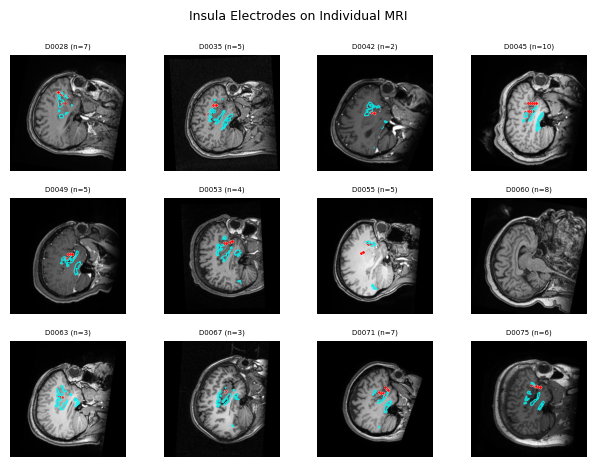

In [16]:
# 批量显示多个subject的insula电极位置 - 改进版
def plot_all_subjects_insula(coords_insula, recon_dir, max_subjects=None):
    """为所有有insula电极的subject生成MRI切片图"""
    subjects = coords_insula['subject'].unique()
    if max_subjects:
        subjects = subjects[:max_subjects]
    
    n_subjects = len(subjects)
    n_cols = min(4, n_subjects)
    n_rows = (n_subjects + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols*cm, 4*n_rows*cm))
    axes = np.atleast_2d(axes).flatten()
    
    for idx, subject_id in enumerate(tqdm(subjects)):
        ax = axes[idx]
        
        # 加载数据
        all_elec_df = load_electrode_coords(subject_id, recon_dir)
        mri_data, affine = load_mri(subject_id, recon_dir)
        parc_data = load_parcellation(subject_id, recon_dir)
        
        if all_elec_df is None or mri_data is None:
            ax.set_title(f'{subject_id}\n(no data)', fontsize=5)
            ax.axis('off')
            continue
        
        # 获取该subject的insula电极
        target_elecs = get_insula_electrodes_for_subject(subject_id, coords_insula)
        elec_df = all_elec_df[all_elec_df['name'].isin(target_elecs)]
        
        if len(elec_df) == 0:
            elec_df = all_elec_df[all_elec_df['name'].apply(
                lambda x: any(t in x for t in target_elecs)
            )]
        
        if len(elec_df) == 0:
            ax.set_title(f'{subject_id}\n(no match)', fontsize=5)
            ax.axis('off')
            continue
        
        # 获取voxel坐标
        voxel_coords = []
        for _, row in elec_df.iterrows():
            ras = np.array([row['x'], row['y'], row['z']])
            vox = ras_to_voxel(ras, affine)
            voxel_coords.append(vox)
        voxel_coords = np.array(voxel_coords)
        
        # Sagittal切片
        x_slice = int(np.median(voxel_coords[:, 0]))
        
        # 判断左右半球
        is_left = x_slice > mri_data.shape[0] // 2
        insula_labels = INSULA_LABELS_LH if is_left else INSULA_LABELS_RH
        
        # Sagittal view
        mri_slice = mri_data[x_slice, :, :].T
        ax.imshow(mri_slice, cmap='gray', origin='lower', aspect='equal')
        
        # 添加insula轮廓
        if parc_data is not None:
            parc_slice = parc_data[x_slice, :, :].T
            insula_mask = np.isin(parc_slice, insula_labels)
            if insula_mask.any():
                ax.contour(insula_mask, levels=[0.5], colors=['cyan'], linewidths=0.8, alpha=0.8)
        
        # 显示电极
        for vox in voxel_coords:
            dist = abs(vox[0] - x_slice)
            if dist < 10:
                alpha = max(0.5, 1 - dist/10)
                size = max(8, 15 - dist)
                size=5
                ax.scatter(vox[1], vox[2], c='red', s=size, alpha=alpha, 
                          edgecolors='white', linewidths=0.2)
        
        ax.set_title(f'{subject_id} (n={len(elec_df)})', fontsize=5)
        ax.axis('off')
    
    # 隐藏多余的axes
    for idx in range(len(subjects), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Insula Electrodes on Individual MRI', fontsize=fontsize+2)
    plt.tight_layout()
    plt.show()

# 显示前12个subject
plot_all_subjects_insula(coords_insula, recon_dir, max_subjects=12)

Testing coronal view with subject: D0086


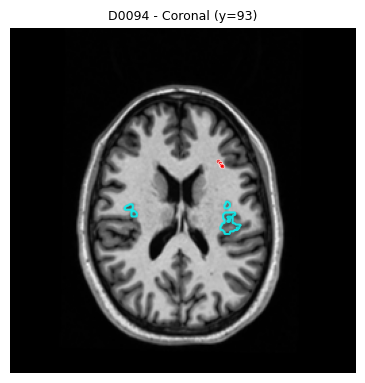

,name,x,y,z
42,LIA4,-26.625,23.4375,24.3125
43,LIA3,-27.750,22.1250,20.8750
44,LIA2,-28.875,20.8125,17.4375
45,LIA1,-30.000,19.5000,14.0000


In [18]:
# Coronal view - 更好地展示 insula vs operculum
def plot_electrode_coronal(subject_id, coords_insula, recon_dir, slice_offset=0):
    """在MRI coronal切片上显示电极位置，类似Radiopaedia图片"""
    # 加载数据
    all_elec_df = load_electrode_coords(subject_id, recon_dir)
    mri_data, affine = load_mri(subject_id, recon_dir)
    parc_data = load_parcellation(subject_id, recon_dir)
    
    if all_elec_df is None or mri_data is None:
        return None
    
    # 获取该subject的insula电极名称
    target_elecs = get_insula_electrodes_for_subject(subject_id, coords_insula)
    if len(target_elecs) == 0:
        print(f"No insula electrodes found for {subject_id}")
        return None
    
    # 筛选目标电极
    elec_df = all_elec_df[all_elec_df['name'].isin(target_elecs)]
    if len(elec_df) == 0:
        elec_df = all_elec_df[all_elec_df['name'].apply(
            lambda x: any(t in x for t in target_elecs)
        )]
    
    if len(elec_df) == 0:
        print(f"Could not match electrodes for {subject_id}")
        return None
    
    # 获取电极的voxel坐标
    voxel_coords = []
    for _, row in elec_df.iterrows():
        ras = np.array([row['x'], row['y'], row['z']])
        vox = ras_to_voxel(ras, affine)
        voxel_coords.append(vox)
    voxel_coords = np.array(voxel_coords)
    
    # 计算coronal切片位置（电极y坐标的中位数）
    y_slice = int(np.median(voxel_coords[:, 1])) + slice_offset
    
    # 绘图
    fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
    
    # Coronal view: mri_data[:, y_slice, :] 取y切片
    # 显示时 x轴是左右(x), z轴是上下(z)
    mri_slice = mri_data[:, y_slice, :].T  # 转置使z轴垂直
    ax.imshow(mri_slice, cmap='gray', origin='lower', aspect='equal')
    
    # 添加insula轮廓 (两侧都显示)
    if parc_data is not None:
        parc_slice = parc_data[:, y_slice, :].T
        # 左侧insula
        insula_mask_lh = np.isin(parc_slice, INSULA_LABELS_LH)
        if insula_mask_lh.any():
            ax.contour(insula_mask_lh, levels=[0.5], colors=['cyan'], linewidths=1.5, alpha=0.8)
        # 右侧insula
        insula_mask_rh = np.isin(parc_slice, INSULA_LABELS_RH)
        if insula_mask_rh.any():
            ax.contour(insula_mask_rh, levels=[0.5], colors=['cyan'], linewidths=1.5, alpha=0.8)
    
    # 显示电极
    for i, vox in enumerate(voxel_coords):
        dist = abs(vox[1] - y_slice)  # y方向距离
        if dist < 15:  # 显示接近切片的电极
            alpha = max(0.5, 1 - dist/15)
            size = max(20, 50 - dist*2)
            size=10
            ax.scatter(vox[0], vox[2], c='red', s=size, alpha=alpha, 
                      edgecolors='white', linewidths=0.5)
    
    ax.set_title(f'{subject_id} - Coronal (y={y_slice})', fontsize=fontsize+2)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return elec_df

# 测试
test_subject = coords_insula['subject'].value_counts().index[0]
print(f"Testing coronal view with subject: {test_subject}")
test_subject='D0094'
plot_electrode_coronal(test_subject, coords_insula, recon_dir, slice_offset=2)

In [7]:
coords_insula['subject'].unique()

array(['D0028', 'D0035', 'D0042', 'D0045', 'D0049', 'D0053', 'D0055',
       'D0060', 'D0063', 'D0067', 'D0071', 'D0075', 'D0079', 'D0084',
       'D0085', 'D0086', 'D0092', 'D0093', 'D0094', 'D0095', 'D0096',
       'D0102', 'D0103', 'D0007', 'D0033', 'D0058', 'D0080', 'D0088',
       'D0090', 'D0032', 'D0038', 'D0047', 'D0065', 'D0101', 'D0117'],
      dtype=object)